In [1]:
import rasterio
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import numpy as np

import os
import rasterio.features as r_feats
from rasterio.plot import show, reshape_as_image
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, mapping, Point
from shapely.ops import cascaded_union

import rasterio.mask
from rasterio.features import rasterize


%matplotlib inline

In [3]:
BASE_FOLDER = './data'

raster_name = '20180618_080602_103d'
raster_filename = f'{raster_name}_3B_AnalyticMS.tif'

shape_folder= 'Vegetation'
clean_shape_name = 'clean_Vegetation_v0.1.shp'

In [21]:
raster_path = os.path.join(BASE_FOLDER, raster_name, raster_filename)
shape_path = os.path.join(BASE_FOLDER, shape_folder, clean_shape_name)
mask_path = os.path.join(BASE_FOLDER, raster_name, f'{raster_filename[:-4]}_mask.tif')

clip_sufix = '_rio_clip.tif'

clipped_raster_path = f'{raster_path[:-4]}{clip_sufix}'
clipped_mask_path = f'{mask_path[:-4]}{clip_sufix}'

In [5]:
def get_contours(self):
    th2 = self.threshold_raster()
    self.rotated_mask = self.rotate_image(th2)
    # self.rota = self.get_largest(self.rotated_mask)
    self.rotated_mask = self.get_largest(self.rotated_mask)
    im2, contours, hierarchy = cv2.findContours(th2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _, self.rotated_contours, _ = cv2.findContours(self.rotated_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise TypeError("Contours wasn't found, Threshold- {} is too high".format(self.mask_value))
    return contours

def polygonize(self, contours, transform=True):
    polygons = []
    for i in tqdm(range(len(contours))):
        c = contours[i]
        n_s = (c.shape[0], c.shape[2])
        if n_s[0] > 2:
            if transform:
                polys = [tuple(i) * self.masked_meta['transform'] for i in c.reshape(n_s)]
            else:
                polys = [tuple(i) for i in c.reshape(n_s)]
            polygons.append(Polygon(polys))
    return polygons

In [8]:
with rasterio.open(raster_path, "r") as src:
    meta = src.meta
    image = src.read()
meta

In [19]:
shapes = gpd.read_file(shape_path)

In [24]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 9124,
 'height': 4612,
 'count': 4,
 'crs': CRS.from_dict(init='epsg:32636'),
 'transform': Affine(3.0, 0.0, 641511.0,
        0.0, -3.0, 5556318.0)}

In [29]:
shapes.head()

,OBJECTID,NATURAL,LANDUSE,WOOD,NAME,OSM_TYPE,OSM_ID,Shape_Leng,Shape_Area,geometry
0,12.0,wood,None,None,None,relation,1535951.0,0.008396,2.042993e-06,"POLYGON ((35.16324789957093 48.49912870022939,..."
1,19.0,None,forest,mixed,None,relation,1746397.0,0.027436,5.358526e-06,"POLYGON ((35.76893110019017 50.15464859985303,..."
2,23.0,heath,None,None,None,relation,1748446.0,0.002648,1.774850e-07,"POLYGON ((35.79248989968914 50.15197420044905,..."
3,24.0,scrub,None,None,None,relation,1749274.0,0.007967,1.063327e-06,"POLYGON ((33.30614970004865 47.89670370021565,..."
4,26.0,heath,None,None,None,relation,1748445.0,0.007137,1.717815e-06,"POLYGON ((35.78844480038725 50.15182939970708,..."


In [38]:
shapes.to_crs(meta['crs'], inplace=True)

In [65]:
local_shapes.to_file()

In [74]:
local_shapes = gpd.read_file(os.path.join(BASE_FOLDER, shape_folder, 'local_shapes'))

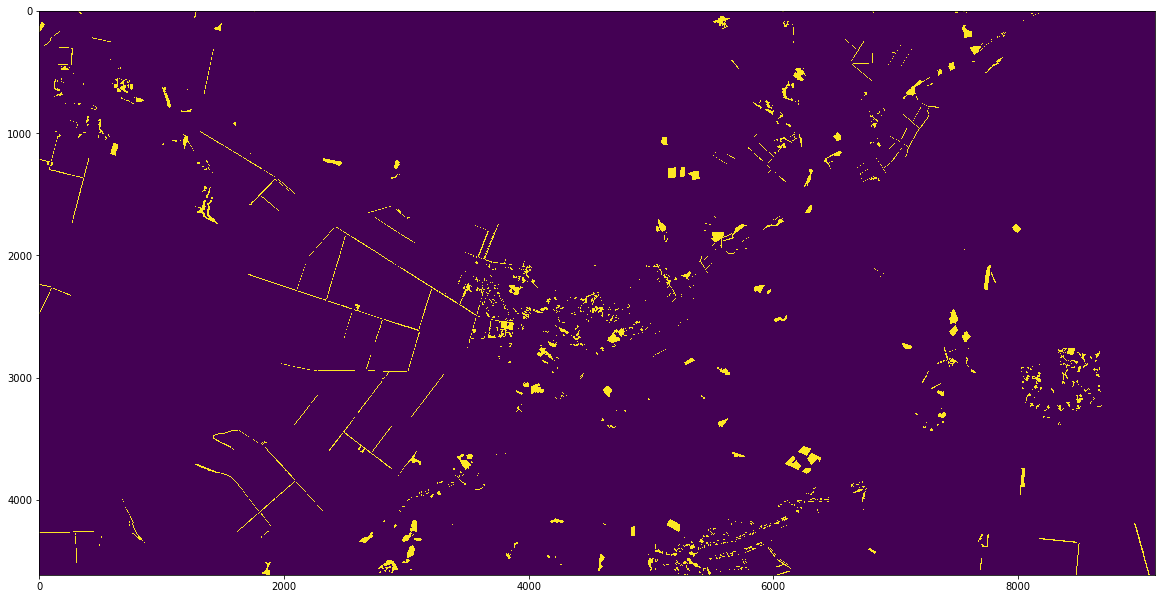

In [67]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

src = rasterio.open(raster_path, "r")

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in local_shapes.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask
src.close()
plt.figure(figsize=(20, 20))
plt.imshow(mask)

In [68]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [70]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open(mask_path, 'w', **bin_mask_meta) as dst:
    dst.write(mask.astype(np.uint16) * 255, 1)

# Tiling 

In [6]:
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box

In [7]:
# minx, miny = 215443.9, 221995.1
# maxx, maxy = 218309.6, 224860.8

minx, miny = 648046.1886071285, 5550695.413550422
maxx, maxy = 652055.6318127569, 5548053.38348493


bbox = box(minx, miny, maxx, maxy)

In [10]:
src = rasterio.open(mask_path)

In [11]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.meta['crs'])

In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [13]:
def clip_roi(source, roi_mask, out_name):
    coords = getFeatures(roi_mask)
    out_img, out_transform = mask(source, shapes=coords, crop=True)
    out_meta = source.meta.copy()
    out_meta.update({"height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform})
    with rasterio.open(out_name, "w", **out_meta) as dest:
        dest.write(out_img)

In [14]:
clipped_path = os.path.join(BASE_FOLDER, raster_name, f'{raster_filename[:-4]}_mask_rio_clip.tif')
clip_roi(src, geo, clipped_path)

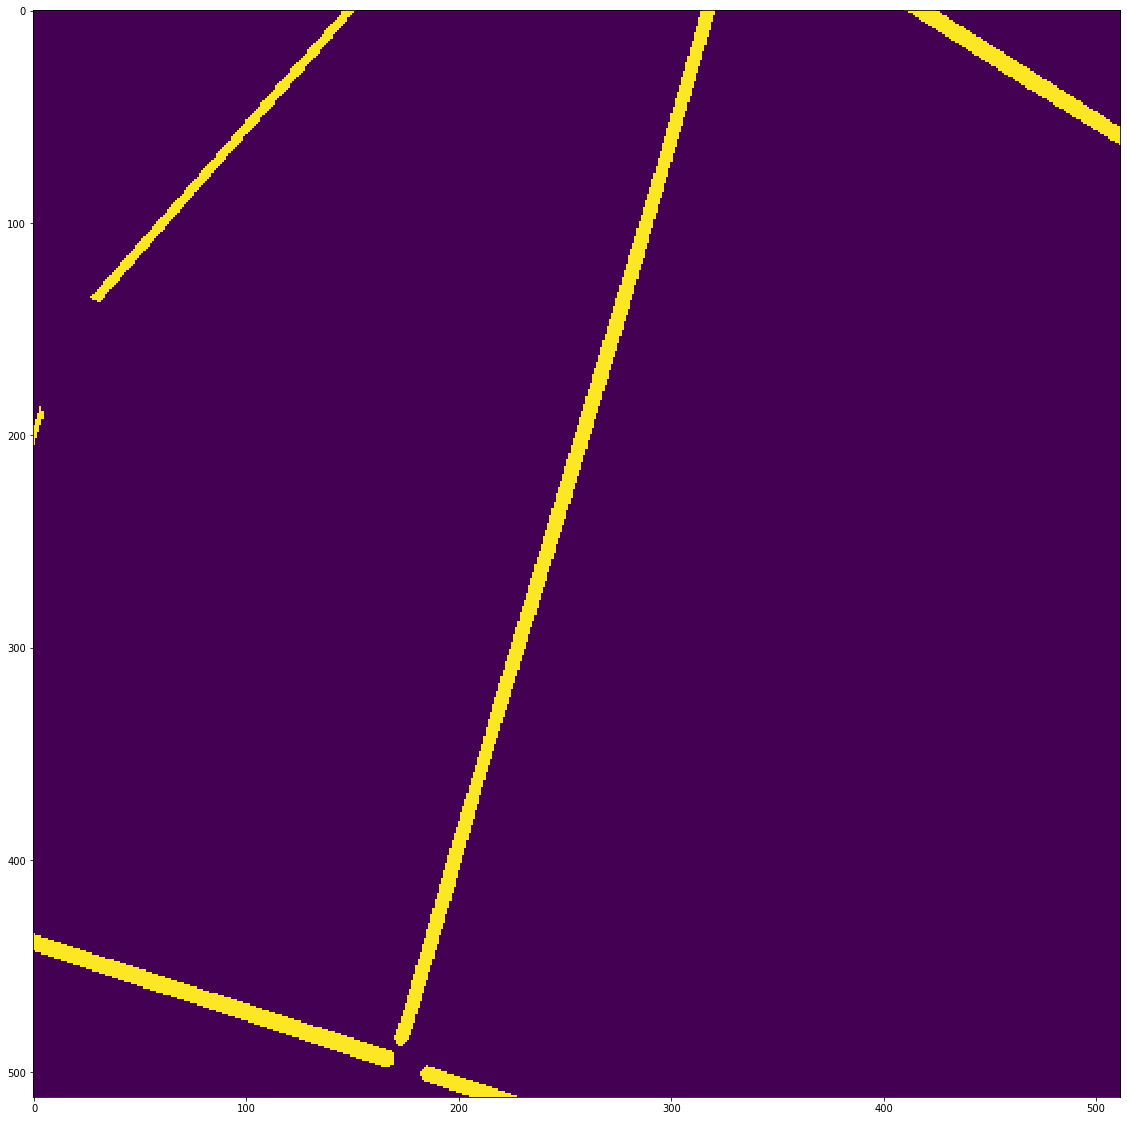

In [41]:
src = rasterio.open(clipped_mask_path)
data = src.read()

plt.figure(figsize=(20,20))
plt.imshow(data[0, :512, :512])

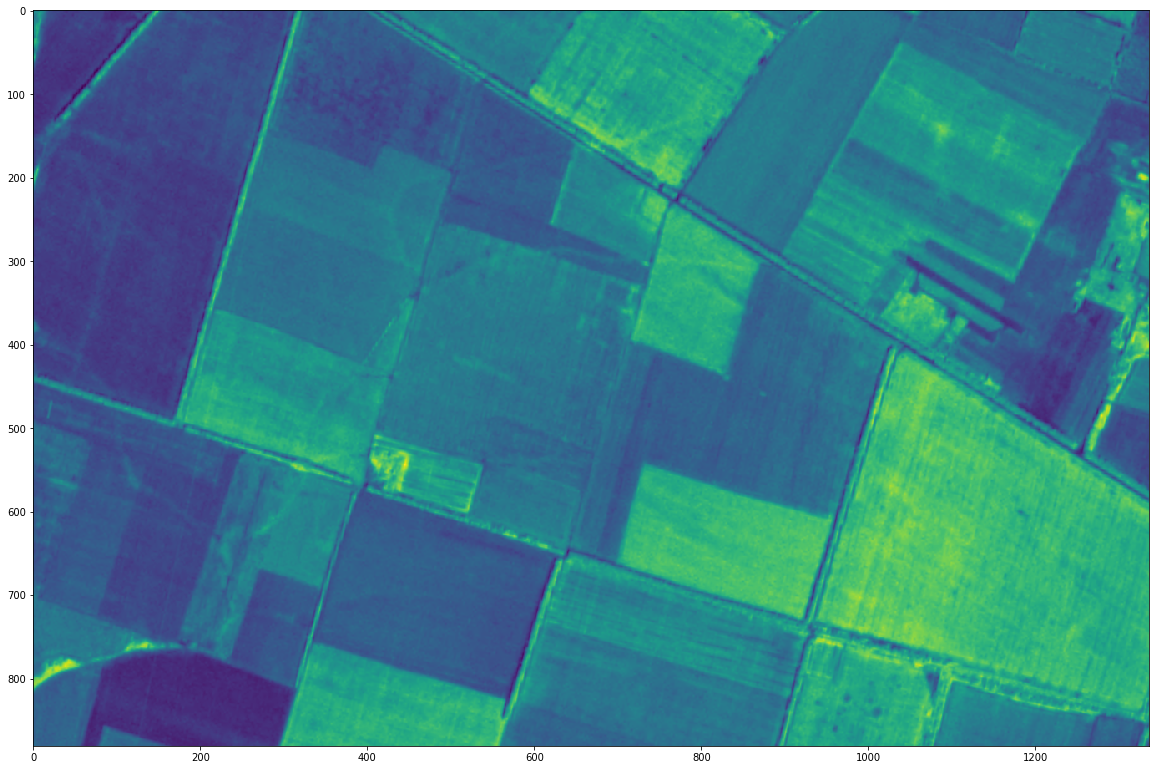

In [22]:
src = rasterio.open(clipped_raster_path)
data = src.read(4)

plt.figure(figsize=(20,20))
plt.imshow(data)

In [173]:
from xml.dom import minidom

xmldoc = minidom.parse(os.path.join(BASE_FOLDER, raster_name, f'{raster_filename[:-4]}_metadata.xml'))
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

print("Conversion coefficients: {}".format(coeffs))

Conversion coefficients: {1: 1.98569596216e-05, 2: 2.10080263206e-05, 3: 2.34592001296e-05, 4: 3.54705810015e-05}


In [193]:
scaled_data = data.copy().astype(np.float64)
for ch, coef in coeffs.items():
    scaled_data[ch-1] *= coef

In [191]:
scaled_clip_data = scaled_data

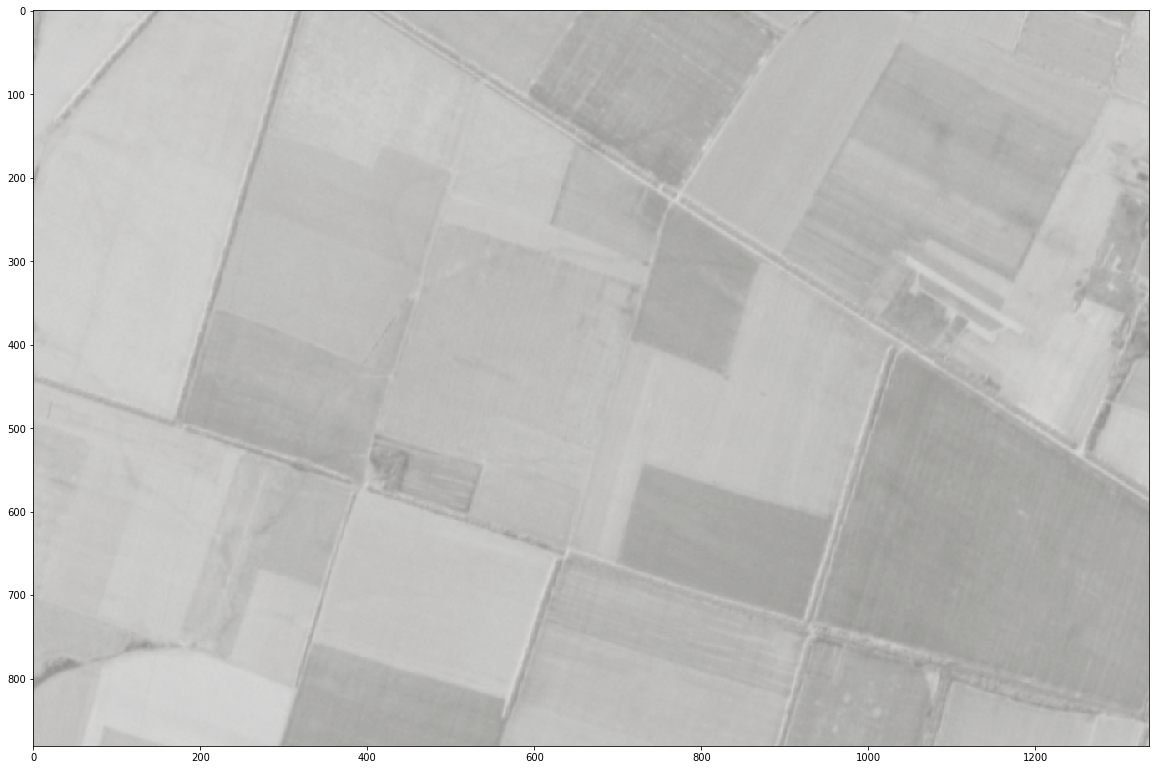

In [192]:
plt.figure(figsize=(20,20))
plt.imshow(reshape_as_image(scaled_clip_data))

# NN overfitting

In [55]:
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm_notebook as tqdm

In [26]:
model = smp.Unet('resnet18', encoder_weights='imagenet')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/evge/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.71MB/s]


In [27]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [52]:
src = rasterio.open(clipped_raster_path)
input_data = src.read()
input_data = input_data[:3, :512, :512] / 10000
src.close()

src = rasterio.open(clipped_mask_path)
mask_data = src.read()
mask_data = mask_data[:, :512, :512] / 255
src.close()

In [86]:
src = rasterio.open(clipped_raster_path)
test_input_data = src.read()
test_input_data = test_input_data[:3, 256:256+512, 256:256+512] / 10000
src.close()

src = rasterio.open(clipped_mask_path)
test_mask_data = src.read()
test_mask_data = test_mask_data[:, 256:256+512, 256:256+512] / 255
src.close()

In [48]:
pred = model(torch.Tensor([input_data]))

In [46]:
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

In [56]:
loss = criterion(pred, torch.Tensor([mask_data]))
loss

tensor(1.6720, grad_fn=<AddBackward0>)

In [65]:
model.cpu()
criterion.cpu()

BCEDiceLoss(
  (bce): BCEWithLogitsLoss()
)

In [69]:
def run_epoch():
    t = tqdm(range(100))
    for i in t:
        optimizer.zero_grad()

        pred = model(torch.FloatTensor([input_data]))
        loss = criterion(pred.cpu(), torch.FloatTensor([mask_data]))

        t.set_postfix(loss=loss.item())

        loss.backward()
        optimizer.step()

run_epoch()

In [77]:
optimizer = torch.optim.SGD([
    {'params': model.decoder.parameters(), 'lr': 5e-3}, 
    {'params': model.encoder.parameters(), 'lr': 5e-5},  
])
run_epoch()

In [78]:
optimizer = torch.optim.SGD([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])
run_epoch()

In [84]:
run_epoch()

In [91]:
run_epoch()
run_epoch()

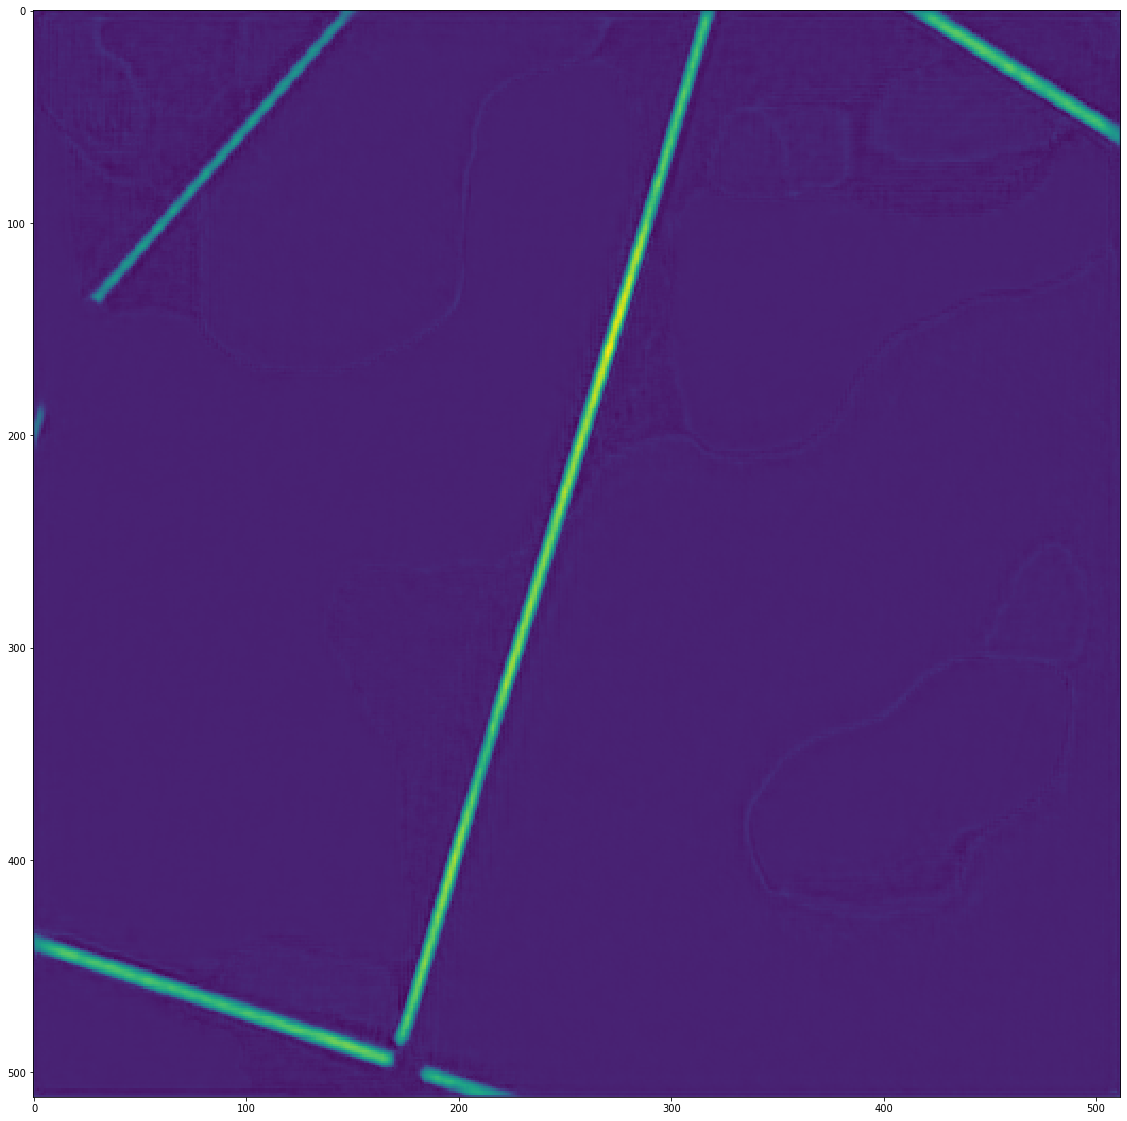

In [92]:
pred = model(torch.FloatTensor([input_data]))
pred_mask = pred.detach().numpy()[0, 0]

plt.figure(figsize=(20,20))
plt.imshow(pred_mask)

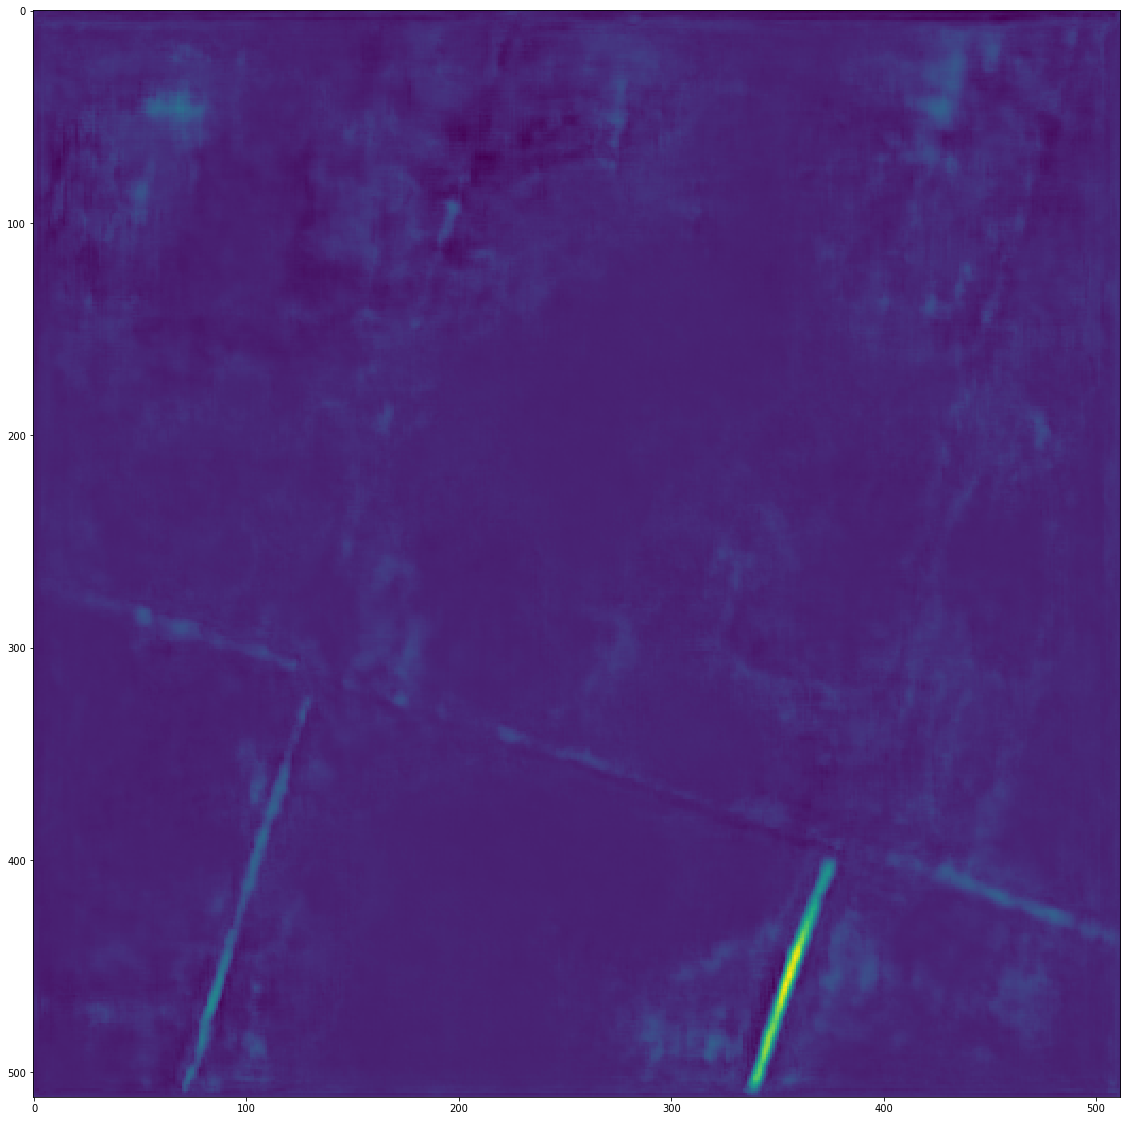

In [93]:
pred = model(torch.FloatTensor([test_input_data]))
pred_mask = pred.detach().numpy()[0, 0]

plt.figure(figsize=(20,20))
plt.imshow(pred_mask)

# Shape preprocessing

In [107]:
shapes = gpd.read_file('data/Vegetation/clean_Vegetation_v0.1.shp')

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [52]:
def norm_shape_coords(shape):
    x, y = shape.exterior.coords.xy
    norm_x = (x - np.mean(x)) / np.std(x)
    norm_y = (y - np.mean(y)) / np.std(y)
    return norm_x, norm_y 

def windbreak_check(shape):
    lin_reg = LinearRegression()
    x, y = norm_shape_coords(shape)
    x = x.reshape(-1, 1)
    lin_reg.fit(x, y)
    return r2_score(y, lin_reg.predict(x))    

In [28]:
shapes.head(10)

,OBJECTID,NATURAL,LANDUSE,WOOD,NAME,OSM_TYPE,OSM_ID,Shape_Leng,Shape_Area,geometry
0,12,wood,None,None,None,relation,1535951.0,0.008396,2.042993e-06,"POLYGON ((35.16324789957093 48.49912870022939,..."
1,19,None,forest,mixed,None,relation,1746397.0,0.027436,5.358526e-06,"POLYGON ((35.76893110019017 50.15464859985303,..."
2,23,heath,None,None,None,relation,1748446.0,0.002648,1.774850e-07,"POLYGON ((35.79248989968914 50.15197420044905,..."
3,24,scrub,None,None,None,relation,1749274.0,0.007967,1.063327e-06,"POLYGON ((33.30614970004865 47.89670370021565,..."
4,26,heath,None,None,None,relation,1748445.0,0.007137,1.717815e-06,"POLYGON ((35.78844480038725 50.15182939970708,..."
5,27,None,forest,None,None,relation,1748442.0,0.006061,3.274044e-07,"POLYGON ((35.79365180039031 50.1522001002545, ..."
6,28,wood,None,None,None,relation,1754978.0,0.016117,4.727564e-06,"POLYGON ((30.51390340042167 50.45625840010513,..."
7,31,heath,None,None,None,relation,1748444.0,0.009233,2.112358e-06,"POLYGON ((35.78877480031684 50.15284229983234,..."
8,32,None,forest,None,None,relation,1748333.0,0.017319,1.450630e-06,"POLYGON ((35.75743669964402 50.17391960000958,..."
9,36,None,forest,None,None,relation,1757944.0,0.019172,2.032439e-06,"POLYGON ((35.7509914995581 50.16779939962265, ..."


In [100]:
# drop a few nones
nones = shapes['geometry'].apply(lambda x: isinstance(x, type(None)))
shapes.drop(shapes[nones].index, inplace=True)

In [125]:
# saparate multipolygons from usual ones
multipolygons_bool = shapes['geometry'].apply(lambda x: isinstance(x, MultiPolygon))
multipolygons = shapes.loc[multipolygons_bool]
multipolygons_idx = multipolygons.index
shapes.drop(multipolygons_idx, inplace=True)

In [131]:
# convert multipolygons to a series of polygons
new_polies = []
for _, multipoly in multipolygons.iterrows():
    geoms = multipoly['geometry'].geoms
    for geom in geoms:
        new_poly = multipoly[['NATURAL', 'LANDUSE', 'WOOD', 'NAME', 'OSM_TYPE']]
        new_poly['geometry'] = geom
        new_poly['Shape_Leng'] = geom.length
        new_poly['Shape_Area'] = geom.area
        new_polies.append(new_poly)

In [134]:
new_polies_df = gpd.GeoDataFrame(new_polies)

In [141]:
type(new_polies_df.iloc[0]['NAME'])

NoneType

In [142]:
new_shapes = gpd.pd.concat([shapes, new_polies_df], sort=False)

In [151]:
new_shapes.columns

Index(['OBJECTID', 'NATURAL', 'LANDUSE', 'WOOD', 'NAME', 'OSM_TYPE', 'OSM_ID',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [159]:
new_shapes.to_file('data/Vegetation/clean_Vegetation_v0.1.shp')

In [91]:
shapes.iloc[i]['geometry'].convex_hull.area

1.0014863836204277e-05

In [160]:
new_shapes['r2_fit_score'] = new_shapes['geometry'].apply(windbreak_check)

In [162]:
valid_shapes_bool = new_shapes['r2_fit_score'] > 0.5
valid_shapes = new_shapes[valid_shapes_bool]
valid_shapes

,OBJECTID,NATURAL,LANDUSE,WOOD,NAME,OSM_TYPE,OSM_ID,Shape_Leng,Shape_Area,geometry,r2_fit_score
5,27.0,None,forest,None,None,relation,1748442.0,0.006061,3.274044e-07,"POLYGON ((35.79365180039031 50.1522001002545, ...",0.800727
8,32.0,None,forest,None,None,relation,1748333.0,0.017319,1.450630e-06,"POLYGON ((35.75743669964402 50.17391960000958,...",0.997614
9,36.0,None,forest,None,None,relation,1757944.0,0.019172,2.032439e-06,"POLYGON ((35.7509914995581 50.16779939962265, ...",0.972801
10,37.0,None,forest,None,None,relation,1757943.0,0.024776,2.768542e-06,"POLYGON ((35.75153029958369 50.17789559990206,...",0.613668
11,38.0,None,forest,None,None,relation,1757945.0,0.053656,6.093203e-06,"POLYGON ((35.71966359989528 50.18017149981495,...",0.999424
12,51.0,heath,None,None,None,relation,1956325.0,0.020824,6.671001e-06,"POLYGON ((37.69505530016204 48.50492149972746,...",0.505505
18,69.0,heath,None,None,None,relation,1760271.0,0.006798,6.149588e-07,"POLYGON ((33.68574900041608 47.65780820018836,...",0.911631
21,76.0,wood,None,None,None,relation,1305655.0,0.004518,4.835155e-10,"POLYGON ((26.27660517089197 48.09000593502594,...",0.989877
25,84.0,None,forest,None,None,relation,2367049.0,0.005697,6.809767e-07,"POLYGON ((34.51839870043972 49.56495249975814,...",0.537080
26,92.0,None,forest,None,None,relation,2752700.0,0.036039,4.176761e-06,"POLYGON ((24.18785930016662 47.96281699980477,...",0.787779


In [164]:
valid_shapes.to_file('data/Vegetation/valid_poly_v0.1')

transform shape to tif coords

In [45]:
~meta['transform'] * np.array(poly.exterior.coords)[0]

(-25925.039786001667, 21381.78166359663)